# Analysis of SD as a wave phenomenon in 2p recordings
In this script, the spreading depolarization waves are analyzed as waves of high signal, disregarding the cell dynamics, for example. Questions asked are:
* Where does the SD come from, where does it go?
* How many SDs are there (find the manually). Is this a constant over seizures for one mouse?
* Do the SDs always look similar in the same mouse?

### TODO
* add mouse ID to JSON
* Useful for analysis motivation: Masvidal-Codina et al 2021, Characterization of optogenetically-induced cortical spreading depression in awake mice using graphene micro-transistor arrays
* use ideas from paper above to correct for outliers (2.5 SD of mean latency...), 
* T301 tmev d1 1131 (video 2): the first SD is not over yet, but the second waves are already coming. Need to make a sliding interval? I.e. on lower parts, the window for 1st SD is [x,y], for upper parts it is later [x+dt, y+dt]...
* Currently: make rectangles and take mean signal. Anything better?
* Assigning an "activation frame index": is the first maximum within the SD window. First maximum might not be the best statistic. Maybe do something with derivative (finite difference)?

## Import libraries

In [ ]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
from nd2_to_caiman import np_arr_from_nd2
import labrotation.file_handling as fh
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from math import floor, sqrt
from datetime import datetime
import json
from labrotation import json_util

## Open nd2 file (seizure recording)

In [ ]:
nd2_fpath = fh.open_file("Select nd2 file") #"D:/PhD/Data/T386_MatlabTest/T386_20211202_green.nd2"
print(f"Input file selected: {nd2_fpath}")

In [ ]:
nd2_data = np_arr_from_nd2(nd2_fpath)

In [ ]:
n_frames = nd2_data.shape[0]

In [ ]:
nd2_data.dtype

## Find SD waves by hand. Enter (starting frame, ending frame) into SD_frames list

Use NIS-Elements Viewer or the slider below to find the SD onset and end time for each SD

In [ ]:
import param
import bokeh
import pylab as pl
import holoviews as hv
import panel as pn
hv.extension('bokeh', 'matplotlib')

In [ ]:
class PlotFrame(param.Parameterized):
    i_frame                = param.Number(default=0, bounds=(0, n_frames), step=1)
    @param.depends('i_frame')
    def view(self):
        im = hv.Image(np.flip(nd2_data[self.i_frame,:,:], 0), bounds=(0, 0, 512, 512), kdims=["width", "height"]).opts(normalize=True, cmap="twilight", invert_yaxis=True, xlim=(0,512), ylim=(0, 512), aspect="equal", frame_height=400) # need to flip rows and invert yaxis so top left is (0, 0)
        return im

In [ ]:
pn.extension()
p = PlotFrame()

pn.Row(p.view, p.param)  

## Enter manually SD frames: [(onset1, end1), (onset2, end2), ...] 

In [ ]:
SD_frames = [(8604, 8695)]  # strict frames, no buffer before and after
n_SD = len(SD_frames)
#SD_frames = [(9164, 9231), (9232, 9333)]  # manually set the starting points for each wave. Last entry is the end of relevant period

## Define analysis parameters

In [ ]:
# DEFINE PARAMETERS HERE:
# number of points per row and per column in the grid
n_rows = 8
n_cols = 8
# half side length of rectangle centered around points
half_side_len = 31 # 14  # if half_side_len = 3, then rectangle size = (3 + 1 + 3) x (3 + 1 + 3) = 7x7
# offset from edge of FOV. Used to 1. disregard some corner pixels, 2. give place for the rectangles around the grid points.
offset_x = 32 # 20  # ignore this many pixels on both left and right
offset_y = 32 # 20  # ignore this many pixels on both top and bottom


# DERIVED PARAMETERS:
# frame size
frame_width = nd2_data.shape[1]
frame_height = nd2_data.shape[2]
# distance between grid points
x_step = (frame_width - 2*offset_x)//(n_cols-1)
y_step = (frame_height - 2*offset_y)//(n_rows-1)
# to make grid symmetric, calculate leftover and divide it on both sides for both rows and columns
x_leftover = (frame_width - 2*offset_x)%x_step
y_leftover = (frame_height - 2*offset_y)%y_step


# TEST CONSISTENCY OF PARAMETERS
assert(n_rows > 1 and n_cols > 1)  # to be able to make a grid, need at least 2x2 points
assert((half_side_len < offset_x) and (half_side_len < offset_y))  # make sure that the rectangles stay inside FOV
assert(((2*half_side_len + 1) < x_step) and ((2*half_side_len + 1) < y_step ))  # check no overlap between rectangles

## Create array of grid points

In [ ]:
def get_x(i_col):
    return (offset_x + floor(x_leftover/2) + i_col*x_step)

def get_y(i_row):
    return (offset_y + floor(y_leftover/2) + i_row*y_step)

def get_coords(i_row, i_col): 
    """
    given the input video and needed grid size, get coordinates of the grid point as tuple (row_pixel, col_pixel).
    IMPORTANT: it uses the parameters defined above! Changing them will change the output of this function.
    """
    return (get_x(i_col), get_y(i_row))

points = []  # list of grid points: [(x, y), ...]
for i_row in range(n_cols):
    for i_col in range(n_rows):
        points.append(get_coords(i_row,i_col))
    
points_x = []
points_y = []
# list x and y coordinates.
for i_col in range(n_cols):
    points_x.append(get_x(i_col))
for i_row in range(n_rows):
    points_y.append(get_y(i_row))

In [ ]:
# used for visualization of selected grid
grid_spacing_x = frame_width / (n_cols)  # put n_cols evenly spaced points per row
grid_spacing_y = frame_height / (n_rows)

def get_raw_coord(i_col_or_row):  # does not take into account the cropping. Just divides up whole frame in the grid and finds centres
    return ((i_col_or_row + 0.5)*grid_spacing_x)

def get_rect_corners(i_col, i_row):
    # get centre coordinate
    x_center = get_raw_coord(i_col)
    y_center = get_raw_coord(i_row)
    
    # calculate top-left (dir. (0, 0) ) and bottom-right (dir. (n, n)) corners
    x0 = x_center - half_side_len
    x1 = x_center + half_side_len
    
    y0 = y_center - half_side_len
    y1 = y_center + half_side_len
    
    return (x0, y0, x1, y1)

## Show grid on recording

In [ ]:
%matplotlib inline

rects = [Rectangle((points[i][0] - half_side_len, points[i][1] - half_side_len ), (2*half_side_len+1), (2*half_side_len))
                  for i in range(len(points))]
pc = PatchCollection(rects, facecolor="yellow", alpha=0.2, edgecolor="red")
fig, ax = plt.subplots(1, figsize=(18,18))
plt.imshow(nd2_data[0,:,:])
plt.scatter(*zip(*points), color='red')
ax.add_collection(pc)
plt.show()

### Test getCoord()

In [ ]:
test_getCoord = False
if test_getCoord:
    fig = plt.figure(figsize=(18,18))
    plt.imshow(nd2_data[0,:,:])
    plt.scatter(*zip(*points[:5]), color='red')  # should start filling up row after row, from top left.
    plt.show()

# Get grid signal

## Define normalizing function, used for both methods

In [ ]:
def normalize_trace(traces):
    traces_norm = np.empty(traces.shape, dtype=np.float64)
    max_arr = np.empty((n_rows, n_cols),  dtype=nd2_data.dtype)
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            max_arr[i_row, i_col] = max(traces[:, i_row, i_col])
            for i_frame in range(traces.shape[0]):
                traces_norm[i_frame, i_row, i_col] = traces[i_frame, i_row, i_col]/max_arr[i_row, i_col]
    return (traces_norm, max_arr)

# Get trace, first and second derivatives (high RAM requirement)
Recommended is at least 32 GB RAM for 8-9 GB recording

In [ ]:
choice3 = True
if ("traces" in locals()) or ("traces_diff" in locals()) or ("traces_diff_second" in locals()):
    error_msg = "Error: it seems like one or more trace variables are already defined. \
    To avoid loss of data, processing data is aborted.\n\
    Check following variables and save them before proceeding:\n\
    traces\ntraces_diff\ntraces_diff_second\ntraces_norm\ntraces_diff_norm\ntraces_diff_second_norm\nmax_arr\nmax_arr_diff\n\
    max_arr_diff_second"
    choice3 = False
    raise Exception(error_msg)


if choice3:
    traces = np.empty((n_frames, n_rows, n_cols), dtype=nd2_data.dtype)
    traces_diff = np.zeros((n_frames, n_rows, n_cols), dtype=int)
    traces_diff_second = np.zeros((n_frames, n_rows, n_cols), dtype=int)
    nd2_unsigned = nd2_data.astype(np.int32)
    # todo: check if row and column indices are correct! change np original array, check where it changes on plot
    for i_frame in range(n_frames): 
        for i_row in range(n_rows):
            for i_col in range(n_cols):
                # middle point of rectangle to sample from
                x, y = get_coords(i_row, i_col)
                # get trace data
                # 1. simply use data of point:
                # traces[i_frame, i_row, i_col] = nd2_data[i_frame, x, y]
                # 2. use the average of a rectangle centered around point:
                # traces[i_frame, i_row, i_col] = nd2_data[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1].mean()
                # 3. use median of the rectangle:
                traces[i_frame, i_row, i_col] = np.median(nd2_data[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                
                # Derivative:
                # 1. f(x+h) - f(x) / h
                #f_t1 = np.median(nd2_unsigned[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                #f_t0 = np.median(nd2_unsigned[i_frame-1, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                # 2. f(x+h) - f(x-h) / 2h
                try:
                    f_t1 = np.median(nd2_unsigned[i_frame+1, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                    f_t0 = np.median(nd2_unsigned[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                    f_tneg1 = np.median(nd2_unsigned[i_frame-1, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                except IndexError:  # first and last indices will cause f_t0 and f_t1 to access i_frame-1 = -1 and i_frame+1 = n_frames+1
                    f_t1 = 0
                    f_t0 = 0
                    f_tneg1 = 0
                traces_diff[i_frame, i_row, i_col] = f_t1 - f_tneg1
                traces_diff_second[i_frame, i_row, i_col] = f_t1 + f_tneg1 - 2*f_t0
    # create normalized traces
    traces_norm, max_arr = normalize_trace(traces)
    traces_diff_norm, max_arr_diff = normalize_trace(traces_diff)
    traces_diff_second_norm, max_arr_diff_second = normalize_trace(traces_diff)
    del nd2_unsigned

# Alternative: Get trace, first and second derivatives (low RAM usage)

In [ ]:
choice3_lowmem = False
if ("traces" in locals()) or ("traces_diff" in locals()) or ("traces_diff_second" in locals()):
    error_msg = "Error: it seems like one or more trace variables are already defined. \
    To avoid loss of data, processing data is aborted.\n\
    Check following variables and save them before proceeding:\n\
    traces\ntraces_diff\ntraces_diff_second\ntraces_norm\ntraces_diff_norm\ntraces_diff_second_norm\nmax_arr\nmax_arr_diff\n\
    max_arr_diff_second"
    choice3_lowmem = False
    raise Exception(error_msg)
    
    
if choice3_lowmem:
    traces = np.empty((n_frames, n_rows, n_cols), dtype=nd2_data.dtype)
    traces_diff = np.zeros((n_frames, n_rows, n_cols), dtype=int)
    traces_diff_second = np.zeros((n_frames, n_rows, n_cols), dtype=int)  
    # todo: check if row and column indices are correct! change np original array, check where it changes on plot
    for i_frame in range(n_frames):
        if i_frame%100 == 0:
            print(f"Processed frame {i_frame} of {n_frames}") 
        try:
            nd2_unsigned_prev = nd2_data[i_frame-1].astype(np.int32)  # TODO: these can be copied between iterations and maybe save time that way?
            nd2_unsigned_curr = nd2_data[i_frame].astype(np.int32)
            nd2_unsigned_next = nd2_data[i_frame+1].astype(np.int32)
        except IndexError:
            nd2_unsigned_prev = np.zeros((frame_height, frame_width), dtype=np.int32)  # TODO: height and width might be the other way around. If a video is asymmetric resolution, need to test this
            nd2_unsigned_curr = np.zeros((frame_height, frame_width), dtype=np.int32)
            nd2_unsigned_next = np.zeros((frame_height, frame_width), dtype=np.int32)
        for i_row in range(n_rows):
            for i_col in range(n_cols):
                # middle point of rectangle to sample from
                x, y = get_coords(i_row, i_col)
                # get trace data
                # 1. simply use data of point:
                # traces[i_frame, i_row, i_col] = nd2_data[i_frame, x, y]
                # 2. use the average of a rectangle centered around point:
                # traces[i_frame, i_row, i_col] = nd2_data[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1].mean()
                # 3. use median of the rectangle:
                traces[i_frame, i_row, i_col] = np.median(nd2_data[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                
                # Derivative:
                # 1. f(x+h) - f(x) / h
                #f_t1 = np.median(nd2_unsigned[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                #f_t0 = np.median(nd2_unsigned[i_frame-1, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                # 2. f(x+h) - f(x-h) / 2h
                try:
                    f_t1 = np.median(nd2_unsigned_next[x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                    f_t0 = np.median(nd2_unsigned_curr[x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                    f_tneg1 = np.median(nd2_unsigned_prev[x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
                except IndexError:  # first and last indices will cause f_t0 and f_t1 to access i_frame-1 = -1 and i_frame+1 = n_frames+1
                    f_t1 = 0
                    f_t0 = 0
                    f_tneg1 = 0
                try:
                    traces_diff[i_frame, i_row, i_col] = f_t1 - f_tneg1
                    traces_diff_second[i_frame, i_row, i_col] = f_t1 + f_tneg1 - 2*f_t0
                except ValueError:
                    print(f"ValueError at traces_diff assignment at {i_frame}.")
                    traces_diff[i_frame, i_row, i_col] = 0
                    traces_diff_second[i_frame, i_row, i_col] = 0
                    
                    
    # create normalized traces
    traces_norm, max_arr = normalize_trace(traces)
    traces_diff_norm, max_arr_diff = normalize_trace(traces_diff)
    traces_diff_second_norm, max_arr_diff_second = normalize_trace(traces_diff)
    
    # FIXME: probably last frame: 
    # D:\Software\anaconda\envs\py2p\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
    # return _methods._mean(a, axis=axis, dtype=dtype,
    # D:\Software\anaconda\envs\py2p\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
    # ret = ret.dtype.type(ret / rcount)
    #---------------------------------------------------------------------------
    #ValueError                                Traceback (most recent call last)
    #Input In [20], in <module>
    #     41                 f_t0 = 0
    #     42                 f_tneg1 = 0
    #---> 43             traces_diff[i_frame, i_row, i_col] = f_t1 - f_tneg1
    #     44             traces_diff_second[i_frame, i_row, i_col] = f_t1 + f_tneg1 - 2*f_t0
    #     45 # create normalized traces
    #
    #ValueError: cannot convert float NaN to integer

# Visualize results

## Plot trace and derivative (needs method 1 with optional derivative signal)

In [ ]:
def plot_trace_with_diff_norm(i_row, i_col, i_SD):
    assert(i_SD < n_SD)
    %matplotlib inline
    fig = plt.figure(figsize = (18,18))
    plt.plot(traces_norm[:, i_row, i_col])
    plt.plot(traces_diff_norm[:, i_row, i_col])
    plt.xlim(SD_frames[i_SD])
    plt.show()

In [ ]:
plot_trace_with_diff_norm(7,7,0)

### Plot normalized traces per grid. (For high n_rows and n_cols, this might take long!)

In [ ]:
plot_norm_traces = True
if plot_norm_traces:
    fig = plt.figure(figsize = (18,18))
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            plt.plot(traces_norm[:, i_row, i_col])
            #plt.plot(traces_diff_norm[:, i_row, i_col])  # plot derivative
    plt.xlim(SD_frames[0])
    #plt.xlim(8500,10500)
    plt.show()

In [ ]:
def showGridPoint(i_row, i_col):
    """
    Show the grid point that corresponds to i_row and i_col. i_row and i_col start from 0!
    """
    i_selected = i_row*n_cols + i_col  # 2d index to 1d index
    fig, ax = plt.subplots(1, figsize=(18,18))
    plt.imshow(nd2_data[0,:,:])
    plt.scatter(*zip(*points), color='blue')
    # define rectangles not selected
    rects = [Rectangle((points[i][0] - half_side_len, points[i][1] - half_side_len ), (2*half_side_len+1), (2*half_side_len))
                  for i in range(len(points)) if i != i_selected]
    pc1 = PatchCollection(rects, facecolor="yellow", alpha=0.2, edgecolor="red")
    # define selected rectangle
    rect_sel = [Rectangle((points[i_selected][0] - half_side_len, points[i_selected][1] - half_side_len ), (2*half_side_len+1), (2*half_side_len))]
    pc2 = PatchCollection(rect_sel, facecolor="yellow", alpha=0.6, edgecolor="blue")
    plt.scatter(*get_coords(i_row, i_col), color='red')
    ax.add_collection(pc1)
    ax.add_collection(pc2)
    plt.show()
    
# test the showGridPoint function
testShowGridPoint = False
if testShowGridPoint:
    showGridPoint(13, 10)

# Extract onset frames

In [ ]:
def get_onset_grid(traces_norm):
    onset_grid = np.zeros((n_SD, n_rows, n_cols), dtype='uint16')  # length of SD_frames is n_SD + 1 (last entry is end of relevant interval)
    for i_row in range(n_rows): 
        for i_col in range(n_cols):
            for i_SD in range(n_SD):
                max_frames = np.where(traces_norm[SD_frames[i_SD][0]:SD_frames[i_SD][1], i_row, i_col] == max(traces_norm[SD_frames[i_SD][0]:SD_frames[i_SD][1], i_row, i_col]), 1, 0).nonzero()[0]
                if len(max_frames) > 1:  # more maxima found
                    print(f"{len(max_frames)} maxima of grid point {i_row}, {i_col} in SD #{i_SD+1}")
                elif len(max_frames) == 0:
                    print(f"No max frames!")
                max_frame = max_frames[0]  # TODO: how to select between maxima? Use info from neighbours?
                onset_grid[i_SD, i_row, i_col] = max_frame + SD_frames[i_SD][0]  # adjust to whole recording again. TODO: off-by-one error?
    return onset_grid

In [ ]:
onset_grid = get_onset_grid(traces_diff_norm)

In [ ]:
show_colorbar = False
if show_colorbar:
    %matplotlib inline
    i_SD = 1
    fig, ax = plt.subplots(figsize = (18, 18))
    plt.imshow(onset_grid[i_SD, :, :].transpose())  # transpose because imshow expects (x, y), and we provide (row, col) shape
    for i in range(n_rows):
        for j in range(n_cols):
            text = ax.text(j, i, onset_grid[i_SD, j, i],
                           ha="center", va="center", color="w")
    plt.colorbar()

# (Not done yet) create quiver plot

In [ ]:
def getNeighbours(i_row, i_col):
    neighbours_list = []  # [(x, y), ...] format
    for i_row_nb in range(i_row-1, i_row +2):
        for i_col_nb in range(i_col-1, i_col+2):
            if (i_row_nb >= 0) and (i_row_nb < n_rows) and (i_col_nb >= 0) and (i_col_nb < n_cols):
                if not((i_row_nb == i_row) and (i_col_nb == i_col) ):  # exclude cell itself
                    neighbours_list.append((i_col_nb, i_row_nb))  # format is (x, y)
    return neighbours_list

In [ ]:
def getVectors(i_SD):
    vectors_x = np.zeros((n_rows, n_cols), float)
    vectors_y = np.zeros((n_rows, n_cols), float)
    weights = onset_grid[i_SD, :, :]
    for i_row in range(n_rows):  # y coordinate of cell
        for i_col in range(n_cols):  # x coordinate of cell
            mean_x = 0
            mean_y = 0
            neighbours =  getNeighbours(i_row, i_col)
            # loop over neighbouring rectangles. get average vector by weighted sum of the normalized vectors.
            for x, y in neighbours:
                norm_factor = 1/sqrt(pow(x-i_col, 2) + pow(y-i_row, 2))
                weight = weights[x, y]
                mean_x += x*norm_factor*weight
                mean_y += y*norm_factor*weight
            mean_x = mean_x/len(neighbours)
            mean_y = mean_y/len(neighbours)
            vectors_x[i_row, i_col] = mean_x
            vectors_y[i_row, i_col] = mean_y
    return (vectors_x, vectors_y)
            
            
            

In [ ]:
def getVectors(i_SD):
    vectors_x = np.zeros((n_rows, n_cols), float)
    vectors_y = np.zeros((n_rows, n_cols), float)
    weights = onset_grid[i_SD, :, :]
    # loop through each neighbor, find max weight, point that direction
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            x = 0
            y = 0
            neighbours = getNeighbours(i_col, i_row)
            current_max_weight = weights[i_row, i_col]
            for x_n, y_n in neighbours:
                if weights[y, x] > current_max_weight:
                    current_max_weight = weights[y, x]
                    x = x_n
                    y = y_n
            norm_factor = sqrt(x**2 + y**2)
            if norm_factor == 0:
                norm_factor = 1
            vectors_x[i_row, i_col] = x/norm_factor
            vectors_y[i_row, i_col] = y/norm_factor
    return (vectors_x, vectors_y)

## TODO: implement weighting and plot quiver
* https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html
* fix first getVectors that averages neighbors.
* try to rotate plot so that it matches video recording and imshow plot..

In [ ]:
plot_quiver = False
if plot_quiver:
    quiv_x, quiv_y = getVectors(1)
    fig = plt.figure(figsize=(18,18))
    plt.quiver(points_x, points_y, quiv_x, quiv_y)
    plt.show()

# Manually adjust data

## TODO: 
* TODO: separate maximum finding algorithm to be able to flexibly switch and implement new algorithms
* TODO: implement new algorithm that uses derivative signal!
* TODO: implement second derivative
* TODO: implement differentiation over t-2, t-1, t, t+1, t+2... (runge-kutta?)
* check if traces are similar to traces of a rectangle in fiji (Z projection...).
* implement df_over_f from Michaels script (Michael_dff.m in 2p-py)
* implement reading json file
* add traces to json data? also method (median...)
* limit trace extraction to frames in SD_frames
* sliding SD window (to be able to deal with intersections between SDs)
* account for not perfect matching! Although for same-day-recordings, this is not a problem I guess.
* there are actually 3 SDs in T301. So far, the second two appeared always at the same time, but in 1209, the left one is a bit later. Maybe do separate analysis? If so, then how? They collide very quickly.

In [ ]:
import param
import bokeh
import pylab as pl
import holoviews as hv
import panel as pn
hv.extension('bokeh', 'matplotlib')

## Create copy of onset grid for correcting manually
Unfortunately, HoloViews does not have a button to simply click and overwrite the value in onset grid, so the values must continuously be overwritten in this copy of the onset grid.

In [ ]:
onset_grid_corr = onset_grid.copy()

In [ ]:
colmap = "viridis"
if n_SD > 1:
    class GridPlot(param.Parameterized):
        i_row                = param.Number(default=0, bounds=(0, n_rows-1), step=1)
        i_col                = param.Number(default=0, bounds=(0, n_cols-1), step=1)
        i_SD                 = param.Number(default=0, bounds=(0, n_SD-1), step=1)
        ofm                  = param.Number(default=SD_frames[0][0], bounds=(SD_frames[0][0], SD_frames[-1][-1]), step=1)
        trace_plotrange      = param.Range(default=(SD_frames[0][0], SD_frames[0][1]), bounds=(min(SD_frames[0][0], SD_frames[-1][0]) - 20, max(SD_frames[0][1], SD_frames[-1][1]) + 20))


        @param.depends('i_row', 'i_col', 'i_SD', 'ofm', 'trace_plotrange')
        def view(self):
            # create x and y data for plots
            #frames = [i_frame for i_frame in range(SD_frames[self.i_SD][0], SD_frames[self.i_SD][1])]
            #trace_data = traces_norm[SD_frames[self.i_SD][0]:SD_frames[self.i_SD][1], self.i_row, self.i_col]
            #trace_diff_data = traces_diff_norm[SD_frames[self.i_SD][0]:SD_frames[self.i_SD][1], self.i_row, self.i_col]
            #trace_diff_second_data = traces_diff_second_norm[SD_frames[self.i_SD][0]:SD_frames[self.i_SD][1], self.i_row, self.i_col]

            frames = []
            trace_data = []
            trace_diff_data = []
            trace_diff_second_data = []

            @param.depends('i_row', 'i_col', 'i_SD', 'ofm', 'trace_plotrange', watch=True)
            def get_traces():
                frames = [i_frame for i_frame in range(*self.trace_plotrange)]
                trace_data = traces_norm[frames[0]:frames[-1]+1, self.i_row, self.i_col]
                trace_diff_data = traces_diff_norm[frames[0]:frames[-1]+1, self.i_row, self.i_col]
                trace_diff_second_data = traces_diff_second_norm[frames[0]:frames[-1]+1, self.i_row, self.i_col]
                return (frames, trace_data, trace_diff_data, trace_diff_second_data)

            frames, trace_data, trace_diff_data, trace_diff_second_data = get_traces()


            # plot calcium transient and derivative
            trace = hv.Curve(zip(frames, trace_data), kdims = 'frame').opts(framewise=True)
            trace_diff = hv.Curve(zip(frames, trace_diff_data), kdims = 'frame').opts(framewise=True)

            # add vertical line of found maximum
            onset_frame = onset_grid[self.i_SD, self.i_row, self.i_col]
            onset_frame_corr = onset_grid_corr[self.i_SD, self.i_row, self.i_col]
            vline = hv.VLine(onset_frame)
            vline_corr = hv.VLine(onset_frame_corr)
            trace = trace * (vline.opts(color="black")) * (vline_corr.opts(color="green"))

            # plot second derivative
            second_derivative = hv.Curve(zip(frames, trace_diff_second_data), kdims = 'frame').opts(framewise=True)
            second_derivative = second_derivative * vline


            # show recording example image and selected grid rectangle
            # give different names to the kdims variables so that the axes are independent!
            im = hv.Image(np.flip(nd2_data[self.ofm,:,:], 0), bounds=(0, 0, 512, 512), kdims=["width", "height"]).opts(normalize=True, cmap="greens", invert_yaxis=True, xlim=(0,512), ylim=(0, 512)) # need to flip rows and invert yaxis so top left is (0, 0)

            # get selected grid rectangle
            closest = im.closest((get_raw_coord(self.i_row), get_raw_coord(self.i_col)))
            # rect = hv.Rectangles([get_rect_corners(i_row, i_col)]).opts(aspect="equal",frame_width=512, frame_height=512)  # could not make this work easily
            point = hv.Points([closest], kdims = ["width", "height"])

            # add selected grid point to recording
            im = (im * (point.opts(color="red", marker="x", size=20,))).opts(aspect='equal', frame_height=300, xlim=(0, frame_width), ylim=(0,frame_height), xaxis=None, yaxis=None)


            # Add manual correction line
            vline_manual = hv.VLine(self.ofm).opts(color="orange")

            # show grid and selected grid rectangle
            grid = hv.Image(np.flip(onset_grid[self.i_SD, :, :].transpose(), 0), bounds=(0, 0, 512, 512), kdims=["grid_width", "grid_height"]).relabel(colmap).opts(cmap=colmap, invert_yaxis=True, xlim=(0,512), ylim=(0, 512), normalize=True, xaxis=None, yaxis=None) 
            grid = (grid * (point.opts(color="red", marker="x", size=20,))).opts(aspect="equal", frame_height=300, xlim=(0, frame_width), ylim=(0, frame_height))

            # show manually corrected grid
            grid_corrected = hv.Image(np.flip(onset_grid_corr[self.i_SD, :, :].transpose(), 0), bounds=(0, 0, 512, 512), kdims=["grid_c_width", "grid_c_height"]).relabel(colmap).opts(cmap=colmap, invert_yaxis=True, xlim=(0,512), ylim=(0, 512), normalize=True, xaxis=None, yaxis=None) 
            grid_corrected = (grid_corrected * (point.opts(color="red", marker="x", size=20,))).opts(aspect="equal", frame_height=300, xlim=(0, frame_width), ylim=(0, frame_height))


            # add button to overwrite grid point onset time
            def overwrite_on_click(event):
                onset_grid_corr[self.i_SD, self.i_row, self.i_col] = self.ofm
                self.ofm += 1
                self.ofm -= 1  # just to trigger refresh frame
            overwrite_button = pn.widgets.Button(name='Overwrite', button_type='primary')
            overwrite_button.on_click(overwrite_on_click)

            # add button to reset plot range
            @param.depends('trace_plotrange', watch=True)
            def reset_range(event):
                self.trace_plotrange[0] = SD_frames[self.i_SD][0]
                self.trace_plotrange[1] = SD_frames[self.i_SD][1]
            resetrange_button = pn.widgets.Button(name='Reset range', button_type='primary')
            resetrange_button.on_click(reset_range)
            return pn.Row(pn.Column(grid, grid_corrected, im), pn.Column(trace*trace_diff*vline_manual, second_derivative*vline*vline_manual, overwrite_button, resetrange_button)) #pn.Row(pn.Column(im, grid, grid_corrected), pn.Column(trace*trace_diff*vline_manual, second_derivative ),)

else:  # n_SD = 1
    class GridPlot(param.Parameterized):
        i_row                = param.Number(default=0, bounds=(0, n_rows-1), step=1)
        i_col                = param.Number(default=0, bounds=(0, n_cols-1), step=1)
        ofm                  = param.Number(default=SD_frames[0][0], bounds=(SD_frames[0][0], SD_frames[-1][-1]), step=1)
        trace_plotrange      = param.Range(default=(SD_frames[0][0], SD_frames[0][1]), bounds=(min(SD_frames[0][0], SD_frames[-1][0]) - 20, max(SD_frames[0][1], SD_frames[-1][1]) + 20))
        
        
        @param.depends('i_row', 'i_col', 'ofm', 'trace_plotrange')
        def view(self):
            # create x and y data for plots
            #frames = [i_frame for i_frame in range(SD_frames[self.i_SD][0], SD_frames[self.i_SD][1])]
            #trace_data = traces_norm[SD_frames[self.i_SD][0]:SD_frames[self.i_SD][1], self.i_row, self.i_col]
            #trace_diff_data = traces_diff_norm[SD_frames[self.i_SD][0]:SD_frames[self.i_SD][1], self.i_row, self.i_col]
            #trace_diff_second_data = traces_diff_second_norm[SD_frames[self.i_SD][0]:SD_frames[self.i_SD][1], self.i_row, self.i_col]

            frames = []
            trace_data = []
            trace_diff_data = []
            trace_diff_second_data = []

            @param.depends('i_row', 'i_col', 'ofm', 'trace_plotrange', watch=True)
            def get_traces():
                frames = [i_frame for i_frame in range(*self.trace_plotrange)]
                trace_data = traces_norm[frames[0]:frames[-1]+1, self.i_row, self.i_col]
                trace_diff_data = traces_diff_norm[frames[0]:frames[-1]+1, self.i_row, self.i_col]
                trace_diff_second_data = traces_diff_second_norm[frames[0]:frames[-1]+1, self.i_row, self.i_col]
                return (frames, trace_data, trace_diff_data, trace_diff_second_data)

            frames, trace_data, trace_diff_data, trace_diff_second_data = get_traces()


            # plot calcium transient and derivative
            trace = hv.Curve(zip(frames, trace_data), kdims = 'frame').opts(framewise=True)
            trace_diff = hv.Curve(zip(frames, trace_diff_data), kdims = 'frame').opts(framewise=True)

            # add vertical line of found maximum
            onset_frame = onset_grid[0, self.i_row, self.i_col]
            onset_frame_corr = onset_grid_corr[0, self.i_row, self.i_col]
            vline = hv.VLine(onset_frame)
            vline_corr = hv.VLine(onset_frame_corr)
            trace = trace * (vline.opts(color="black")) * (vline_corr.opts(color="green"))

            # plot second derivative
            second_derivative = hv.Curve(zip(frames, trace_diff_second_data), kdims = 'frame').opts(framewise=True)
            second_derivative = second_derivative * vline


            # show recording example image and selected grid rectangle
            # give different names to the kdims variables so that the axes are independent!
            im = hv.Image(np.flip(nd2_data[self.ofm,:,:], 0), bounds=(0, 0, 512, 512), kdims=["width", "height"]).opts(normalize=True, cmap="greens", invert_yaxis=True, xlim=(0,512), ylim=(0, 512)) # need to flip rows and invert yaxis so top left is (0, 0)

            # get selected grid rectangle
            closest = im.closest((get_raw_coord(self.i_row), get_raw_coord(self.i_col)))
            # rect = hv.Rectangles([get_rect_corners(i_row, i_col)]).opts(aspect="equal",frame_width=512, frame_height=512)  # could not make this work easily
            point = hv.Points([closest], kdims = ["width", "height"])

            # add selected grid point to recording
            im = (im * (point.opts(color="red", marker="x", size=20,))).opts(aspect='equal', frame_height=300, xlim=(0, frame_width), ylim=(0,frame_height), xaxis=None, yaxis=None)


            # Add manual correction line
            vline_manual = hv.VLine(self.ofm).opts(color="orange")

            # show grid and selected grid rectangle
            grid = hv.Image(np.flip(onset_grid[0, :, :].transpose(), 0), bounds=(0, 0, 512, 512), kdims=["grid_width", "grid_height"]).relabel(colmap).opts(cmap=colmap, invert_yaxis=True, xlim=(0,512), ylim=(0, 512), normalize=True, xaxis=None, yaxis=None) 
            grid = (grid * (point.opts(color="red", marker="x", size=20,))).opts(aspect="equal", frame_height=300, xlim=(0, frame_width), ylim=(0, frame_height))

            # show manually corrected grid
            grid_corrected = hv.Image(np.flip(onset_grid_corr[0, :, :].transpose(), 0), bounds=(0, 0, 512, 512), kdims=["grid_c_width", "grid_c_height"]).relabel(colmap).opts(cmap=colmap, invert_yaxis=True, xlim=(0,512), ylim=(0, 512), normalize=True, xaxis=None, yaxis=None) 
            grid_corrected = (grid_corrected * (point.opts(color="red", marker="x", size=20,))).opts(aspect="equal", frame_height=300, xlim=(0, frame_width), ylim=(0, frame_height))


            # add button to overwrite grid point onset time
            def overwrite_on_click(event):
                onset_grid_corr[0, self.i_row, self.i_col] = self.ofm
                self.ofm += 1
                self.ofm -= 1  # just to trigger refresh frame
            overwrite_button = pn.widgets.Button(name='Overwrite', button_type='primary')
            overwrite_button.on_click(overwrite_on_click)

            # add button to reset plot range
            @param.depends('trace_plotrange', watch=True)
            def reset_range(event):
                self.trace_plotrange[0] = SD_frames[0][0]
                self.trace_plotrange[1] = SD_frames[0][1]
            resetrange_button = pn.widgets.Button(name='Reset range', button_type='primary')
            resetrange_button.on_click(reset_range)


            return pn.Row(pn.Column(grid, grid_corrected, im), pn.Column(trace*trace_diff*vline_manual, second_derivative*vline*vline_manual, overwrite_button, resetrange_button)) #pn.Row(pn.Column(im, grid, grid_corrected), pn.Column(trace*trace_diff*vline_manual, second_derivative ),)
        

In [ ]:
pn.extension()
p = GridPlot()

pn.Row(p.view, p.param)

# Save results

In [ ]:
from datetime import datetime
import json

## Create file names
Two files are saved: one .npz that contains all the numpy arrays, and one .json that contains the parameters used.

### IMPORTANT if editing seizure, mark it with flag below

In [ ]:
data_is_seizure = True
if data_is_seizure:
    seizure_fname_part = "_seizure"
else:
    seizure_fname_part = ""

In [ ]:
now = datetime.now()
now_string = f"{now.year}-{now.month}-{now.day}_{now.hour}-{now.minute}-{now.second}"
output_fname_root = nd2_fpath.split("/")[-1][:-4]  # get filename without extension and date
output_fname_root += "__" + now_string
output_grid_fname = output_fname_root + "_sdgrid"
output_params_fname = output_fname_root + "_sdgrid_pars"
print(f"Output filenames:\n{output_grid_fname + seizure_fname_part}.npz\n{output_params_fname + seizure_fname_part}.json")

### Create dict of parameters for JSON export

In [ ]:
params_dict = {"filename": nd2_fpath, "n_SD": n_SD, "SD_frames": SD_frames, \
               "n_rows": n_rows, "n_cols": n_cols, "half_side_len": half_side_len, \
               "offset_x": offset_x, "offset_y": offset_y, "frame_width": frame_width, \
               "frame_height": frame_height, "x_step": x_step, "y_step": y_step, \
               "x_leftover": x_leftover, "y_leftover": y_leftover, "points_x": points_x, \
              "points_y": points_y}
print(json.dumps(params_dict, indent=4))

### Choose output directory

In [ ]:
output_dir = fh.open_dir("Select folder to save results.") + "/"
print(f"Going to save\n{output_dir + output_grid_fname + seizure_fname_part + '.json'}\n{output_dir + output_grid_fname + seizure_fname_part + '.npz'}")


### Save files

In [ ]:
# save originally detected onset (onset_grid) as well as manually corrected (onset_grid_corr)
np.savez(output_dir + output_grid_fname + seizure_fname_part, onset_grid=onset_grid, onset_grid_corr=onset_grid_corr, traces=traces, traces_diff=traces_diff, traces_diff_second=traces_diff_second)
# TODO: save params
json_fname = output_dir + output_params_fname + seizure_fname_part + ".json"
with open(json_fname, 'w') as f:
    json.dump(params_dict, f, indent=4)
print(f"Saved arrays to\n{output_dir + output_grid_fname + seizure_fname_part + '.npz'}\nSaved parameters to\n{json_fname}")

# Open and work with loaded data
Run code below if a .npz and a .json file are available

In [ ]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
from nd2_to_caiman import np_arr_from_nd2
import labrotation.file_handling as fh
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from math import floor, sqrt
from datetime import datetime
import json
from labrotation import json_util

## Set folder and file names

In [ ]:
npz_fpath = fh.open_file("Select .npz file for grid analysis")
json_fpath = ".".join(npz_fpath.split(".")[:-1])  # get rid of file extension
json_fpath = json_fpath + "_pars.json"  # add difference and json extension
#json_fpath = fh.open_file("Select .json file for grid analysis")
print(f"npz file:\n{npz_fpath}\njson file:\n{json_fpath}")

## Load data

In [ ]:
data = np.load(npz_fpath)
data.files  # ['onset_grid', 'onset_grid_corr', 'traces', 'traces_diff', 'traces_diff_second']

In [ ]:
with open(json_fpath, 'r') as f:
    js = json.load(f)

## Assign variables

In [ ]:
import os.path

In [ ]:
onset_grid = data["onset_grid"]
onset_grid_corr = data["onset_grid_corr"]
traces = data["traces"]
traces_diff = data["traces_diff"]
traces_diff_second = data["traces_diff_second"]

filename = js["filename"]

if not os.path.exists(filename):
    for DRIVE in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
        filename = DRIVE + filename[1:]
        if os.path.exists(filename):
            print(f"Found file on drive {DRIVE}")
            break
n_SD = js["n_SD"]
SD_frames = js["SD_frames"]
n_rows = js["n_rows"]
n_cols = js["n_cols"]
half_side_len = js["half_side_len"]
offset_x = js["offset_x"]
offset_y = js["offset_y"]
frame_width = js["frame_width"]
frame_height = js["frame_height"]
x_step = js["x_step"]
y_step = js["y_step"]
x_leftover = js["x_leftover"]
y_leftover = js["y_leftover"]
points_x = js["points_x"]
points_y = js["points_y"]

# Open nd2 (needed for visualizing frames below)
nd2_data = np_arr_from_nd2(filename)
nd2_fpath = filename

# TEST CONSISTENCY OF PARAMETERS
assert(n_rows > 1 and n_cols > 1)  # to be able to make a grid, need at least 2x2 points
assert((half_side_len < offset_x) and (half_side_len < offset_y))  # make sure that the rectangles stay inside FOV
assert(((2*half_side_len + 1) < x_step) and ((2*half_side_len + 1) < y_step ))  # check no overlap between rectangles

In [ ]:
# used for visualization of selected grid
grid_spacing_x = frame_width / (n_cols)  # put n_cols evenly spaced points per row
grid_spacing_y = frame_height / (n_rows)

def get_raw_coord(i_col_or_row):  # does not take into account the cropping. Just divides up whole frame in the grid and finds centres
    return ((i_col_or_row + 0.5)*grid_spacing_x)

def get_rect_corners(i_col, i_row):
    # get centre coordinate
    x_center = get_raw_coord(i_col)
    y_center = get_raw_coord(i_row)
    
    # calculate top-left (dir. (0, 0) ) and bottom-right (dir. (n, n)) corners
    x0 = x_center - half_side_len
    x1 = x_center + half_side_len
    
    y0 = y_center - half_side_len
    y1 = y_center + half_side_len
    
    return (x0, y0, x1, y1)

## Do normalization
Code is same as above except for dtype

In [ ]:
def normalize_trace(traces):
    traces_norm = np.empty(traces.shape, dtype=np.float64)
    max_arr = np.empty((n_rows, n_cols),  dtype=traces.dtype)
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            max_arr[i_row, i_col] = max(traces[:, i_row, i_col])
            for i_frame in range(traces.shape[0]):
                traces_norm[i_frame, i_row, i_col] = traces[i_frame, i_row, i_col]/max_arr[i_row, i_col]
    return (traces_norm, max_arr)

In [ ]:
traces_norm, max_arr = normalize_trace(traces)
traces_diff_norm, max_arr_diff = normalize_trace(traces_diff)
traces_diff_second_norm, max_arr_diff_second = normalize_trace(traces_diff) 

## Do review again
Code is same as above

In [ ]:
import param
import bokeh
import pylab as pl
import holoviews as hv
import panel as pn
hv.extension('bokeh', 'matplotlib')

In [ ]:
colmap = "viridis"
class GridPlot(param.Parameterized):
    i_row                = param.Number(default=0, bounds=(0, n_rows-1), step=1)
    i_col                = param.Number(default=0, bounds=(0, n_cols-1), step=1)
    i_SD                 = param.Number(default=0, bounds=(0, n_SD-1), step=1)
    ofm                  = param.Number(default=SD_frames[0][0], bounds=(SD_frames[0][0]-10, SD_frames[-1][-1]+10), step=1)
    trace_plotrange      = param.Range(default=(SD_frames[0][0], SD_frames[0][1]), bounds=(min(SD_frames[0][0], SD_frames[-1][0]) - 20, max(SD_frames[0][1], SD_frames[1][1]) + 20))
    
    
    @param.depends('i_row', 'i_col', 'i_SD', 'ofm', 'trace_plotrange')
    def view(self):
        # create x and y data for plots
        #frames = [i_frame for i_frame in range(SD_frames[self.i_SD][0], SD_frames[self.i_SD][1])]
        #trace_data = traces_norm[SD_frames[self.i_SD][0]:SD_frames[self.i_SD][1], self.i_row, self.i_col]
        #trace_diff_data = traces_diff_norm[SD_frames[self.i_SD][0]:SD_frames[self.i_SD][1], self.i_row, self.i_col]
        #trace_diff_second_data = traces_diff_second_norm[SD_frames[self.i_SD][0]:SD_frames[self.i_SD][1], self.i_row, self.i_col]
        
        frames = []
        trace_data = []
        trace_diff_data = []
        trace_diff_second_data = []
        
        @param.depends('i_row', 'i_col', 'i_SD', 'ofm', 'trace_plotrange', watch=True)
        def get_traces():
            frames = [i_frame for i_frame in range(*self.trace_plotrange)]
            trace_data = traces_norm[frames[0]:frames[-1]+1, self.i_row, self.i_col]
            trace_diff_data = traces_diff_norm[frames[0]:frames[-1]+1, self.i_row, self.i_col]
            trace_diff_second_data = traces_diff_second_norm[frames[0]:frames[-1]+1, self.i_row, self.i_col]
            return (frames, trace_data, trace_diff_data, trace_diff_second_data)
        
        frames, trace_data, trace_diff_data, trace_diff_second_data = get_traces()
        
        
        # plot calcium transient and derivative
        trace = hv.Curve(zip(frames, trace_data), kdims = 'frame').opts(framewise=True)
        trace_diff = hv.Curve(zip(frames, trace_diff_data), kdims = 'frame').opts(framewise=True)
        
        # add vertical line of found maximum
        onset_frame = onset_grid[self.i_SD, self.i_row, self.i_col]
        onset_frame_corr = onset_grid_corr[self.i_SD, self.i_row, self.i_col]
        vline = hv.VLine(onset_frame)
        vline_corr = hv.VLine(onset_frame_corr)
        trace = trace * (vline.opts(color="black")) * (vline_corr.opts(color="green"))
        
        # plot second derivative
        second_derivative = hv.Curve(zip(frames, trace_diff_second_data), kdims = 'frame').opts(framewise=True)
        second_derivative = second_derivative * vline
        
        
        # show recording example image and selected grid rectangle
        # give different names to the kdims variables so that the axes are independent!
        im = hv.Image(np.flip(nd2_data[self.ofm,:,:], 0), bounds=(0, 0, 512, 512), kdims=["width", "height"]).opts(normalize=True, cmap="twilight", invert_yaxis=True, xlim=(0,512), ylim=(0, 512)) # need to flip rows and invert yaxis so top left is (0, 0)
    
        # get selected grid rectangle
        closest = im.closest((get_raw_coord(self.i_row), get_raw_coord(self.i_col)))
        # rect = hv.Rectangles([get_rect_corners(i_row, i_col)]).opts(aspect="equal",frame_width=512, frame_height=512)  # could not make this work easily
        point = hv.Points([closest], kdims = ["width", "height"])
        
        # add selected grid point to recording
        im = (im * (point.opts(color="red", marker="x", size=20,))).opts(aspect='equal', frame_height=300, xlim=(0, frame_width), ylim=(0,frame_height), xaxis=None, yaxis=None)
        
        
        # Add manual correction line
        vline_manual = hv.VLine(self.ofm).opts(color="orange")
    
        # show grid and selected grid rectangle
        grid = hv.Image(np.flip(onset_grid[self.i_SD, :, :].transpose(), 0), bounds=(0, 0, 512, 512), kdims=["grid_width", "grid_height"]).relabel(colmap).opts(cmap=colmap, invert_yaxis=True, xlim=(0,512), ylim=(0, 512), normalize=True, xaxis=None, yaxis=None) 
        grid = (grid * (point.opts(color="red", marker="x", size=20,))).opts(aspect="equal", frame_height=300, xlim=(0, frame_width), ylim=(0, frame_height))
        
        # show manually corrected grid
        grid_corrected = hv.Image(np.flip(onset_grid_corr[self.i_SD, :, :].transpose(), 0), bounds=(0, 0, 512, 512), kdims=["grid_c_width", "grid_c_height"]).relabel(colmap).opts(cmap=colmap, invert_yaxis=True, xlim=(0,512), ylim=(0, 512), normalize=True, xaxis=None, yaxis=None) 
        grid_corrected = (grid_corrected * (point.opts(color="red", marker="x", size=20,))).opts(aspect="equal", frame_height=300, xlim=(0, frame_width), ylim=(0, frame_height))
    
        
        # add button to overwrite grid point onset time
        def overwrite_on_click(event):
            onset_grid_corr[self.i_SD, self.i_row, self.i_col] = self.ofm
            self.ofm += 1
            self.ofm -= 1  # just to trigger refresh frame
        overwrite_button = pn.widgets.Button(name='Overwrite', button_type='primary')
        overwrite_button.on_click(overwrite_on_click)
        
        # add button to reset plot range
        @param.depends('trace_plotrange', watch=True)
        def reset_range(event):
            self.trace_plotrange[0] = SD_frames[self.i_SD][0]
            self.trace_plotrange[1] = SD_frames[self.i_SD][1]
        resetrange_button = pn.widgets.Button(name='Reset range', button_type='primary')
        resetrange_button.on_click(reset_range)
        
    
        return pn.Row(pn.Column(grid, grid_corrected, im), pn.Column(trace*trace_diff*vline_manual, second_derivative*vline*vline_manual, overwrite_button, resetrange_button)) #pn.Row(pn.Column(im, grid, grid_corrected), pn.Column(trace*trace_diff*vline_manual, second_derivative ),)

In [ ]:
pn.extension()
p = GridPlot()

pn.Row(p.view, p.param)  
#black vertical line in trace is algorithm-detected onset frame, green is manually corrected, orange is current selected frame

In [ ]:
onset_grid_corr[0]

# Do not forget to save the modified data again!

# Compare SD waves of different seizures
### Restart kernel before, to clear all variables. Do not forget to save the results beforehand!

In [1]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from nd2_to_caiman import np_arr_from_nd2
import labrotation.file_handling as fh
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from math import floor, sqrt
from datetime import datetime
import json
from labrotation import json_util
import os

## Open all npz and json files

In [3]:
npz_fpath = " "
json_fpath = " "
i = 1

npz_structs = []  # list containing npz data
json_dicts = []  # list containing json data, same order as npz_structs


def isValidFile(fpath: str) -> bool:
    """
    Check if the file given match criteria making it valid. Right now, just check if string is not empty.
    """
    return len(fpath) > 0

while True:
    npz_fpath = fh.open_file("Select .npz file for grid analysis")
    # strip npz fpath from ".npz"
    # then add _pars.json to filename
    # to get the json file corresponding to the npz file.
    json_fpath = os.path.abspath(".".join(npz_fpath.split(".")[:-1]) + "_pars.json")
    json_fpath_alt = os.path.abspath(".".join(npz_fpath.split(".")[:-1])[:-8] + "_pars_seizure.json") # remove _seizure, add _pars_seizure.json
    print(json_fpath_alt)
    if not(isValidFile(npz_fpath) and isValidFile(json_fpath)):  # done opening files if one of selected files is not "valid"
        print(f"Loading {i-1} files done, as received invalid file names:\n{npz_fpath}\n{json_fpath}\n")
        break
    print(f"{i}. Opening\nnpz file:\n\{npz_fpath}\njson file:\n{json_fpath}\n")
    npz_data = np.load(npz_fpath)
    npz_structs.append(npz_data)
    if os.path.exists(json_fpath):
        with open(json_fpath, 'r') as f:
            js = json.load(f)
            json_dicts.append(js)
    elif os.path.exists(json_fpath_alt):
        with open(json_fpath_alt, 'r') as f:
            js = json.load(f)
            json_dicts.append(js)
    else:
        raise Exception(f"Following json file paths were tried and file was not found:\n{json_fpath}\n{json_fpath_alt}")
    i += 1

F:\TwoPhoton\tmev\T333\T333_tmev_d2\T333_tmev_d2_21102020_FOV_005__2022-9-22_9-23-25_sdgrid_pars_seizure.json
1. Opening
npz file:
\F:/TwoPhoton/tmev/T333/T333_tmev_d2/T333_tmev_d2_21102020_FOV_005__2022-9-22_9-23-25_sdgrid_seizure.npz
json file:
F:\TwoPhoton\tmev\T333\T333_tmev_d2\T333_tmev_d2_21102020_FOV_005__2022-9-22_9-23-25_sdgrid_seizure_pars.json

F:\TwoPhoton\tmev\T333\T333_tmev_d2\T333_tmev_d2_21102020_FOV_007__2022-9-22_9-38-0_sdgrid_pars_seizure.json
2. Opening
npz file:
\F:/TwoPhoton/tmev/T333/T333_tmev_d2/T333_tmev_d2_21102020_FOV_007__2022-9-22_9-38-0_sdgrid_seizure.npz
json file:
F:\TwoPhoton\tmev\T333\T333_tmev_d2\T333_tmev_d2_21102020_FOV_007__2022-9-22_9-38-0_sdgrid_seizure_pars.json

F:\TwoPhoton\tmev\T333\T333_tmev_d2\T333_tmev_d2_21102020_FOV_009__2022-9-22_9-47-46_sdgrid_pars_seizure.json
3. Opening
npz file:
\F:/TwoPhoton/tmev/T333/T333_tmev_d2/T333_tmev_d2_21102020_FOV_009__2022-9-22_9-47-46_sdgrid_seizure.npz
json file:
F:\TwoPhoton\tmev\T333\T333_tmev_d2\T333

In [4]:
# convert uint16 to int32. Range: -2 billion to 2 billion...
# Note: int16 would cover ~-32 000 to 32 000 which would be enough and half the memory, but the memory saved that way would only be relevant if we kept the 512x512 pixels.
onset_grids = [np.asarray(data["onset_grid_corr"], dtype=np.int32) for data in npz_structs]  # [ [video1_sd1, video1_sd2, ...], [video2_sd1, ...], ... ]

In [5]:
n_SD = onset_grids[0].shape[0]
for i in range(len(onset_grids)):  # test that all recordings have the same number of SD recognized
    assert(onset_grids[i].shape[0] == n_SD)
    
n_vids = len(onset_grids)

print(f"Detected {n_vids} videos, {n_SD} SDs per seizure")

Detected 3 videos, 1 SDs per seizure


## Normalize data
the onset grids contain the frames of SD arrival. Need to normalize them by finding min and taking it as 0.

### Define normalization

In [6]:
def normalize_grid(grid):
    """
    'Normalizes' the 2d np array (assumed to be uint16) and returns the normalized grid. Does not change the grid variable.
    """
    median_val = np.floor(np.median(grid))  # work with median to counter the outliers (regions where SD was not detected)
    grid_norm = grid.copy()
    n_rows, n_cols = grid.shape
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            grid_norm[i_row, i_col] -= median_val
    return grid_norm

### Test normalize function
Change this test if normalize_grid() changes!

In [7]:
# array:
#
# 1 2 3
# 4 5 6
#
# median floor is 3 (3.5)
#
# normalized should be:
#
# -2 -1 0
#  1  2 3

test_arr = np.array([[1, 2, 3], [4, 5, 6]], dtype=np.int32)
test_arr_norm = normalize_grid(test_arr)
assert(np.array_equal(test_arr_norm, np.array([[-2, -1, 0], [1, 2, 3]], dtype=np.int32)))
del test_arr, test_arr_norm

### Apply normalization function

In [8]:
onset_grids_norm = [ [normalize_grid(onset_grids[i_vid][i_SD]) for i_SD in range(n_SD)] for i_vid in range(n_vids) ] 

## Create differences in onset

In [9]:
# onset_grids_diffs = [ [(grid[vid1][SD0] - grid[vid0][sd0]), (grid[vid1][SD1] - grid[vid0][sd1]), ...], [(grid[vid2][SD0] - grid[vid1][sd0]), (grid[vid2][SD1] - grid[vid1][sd1]), ...]  ]
# i.e.
# onset_grids_diffs[i_diff][i_SD]:
#    i_diff: access the difference between videos (i_diff+1) and (i_diff).
#    i_SD: access the SD number i_SD
#   both 0-indexing.
onset_grids_diffs = [ [onset_grids_norm[i_vid][i_SD] - onset_grids_norm[i_vid-1][i_SD] for i_SD in range(n_SD)] for i_vid in range(1, n_vids) ]

In [10]:
len(onset_grids_diffs)

2

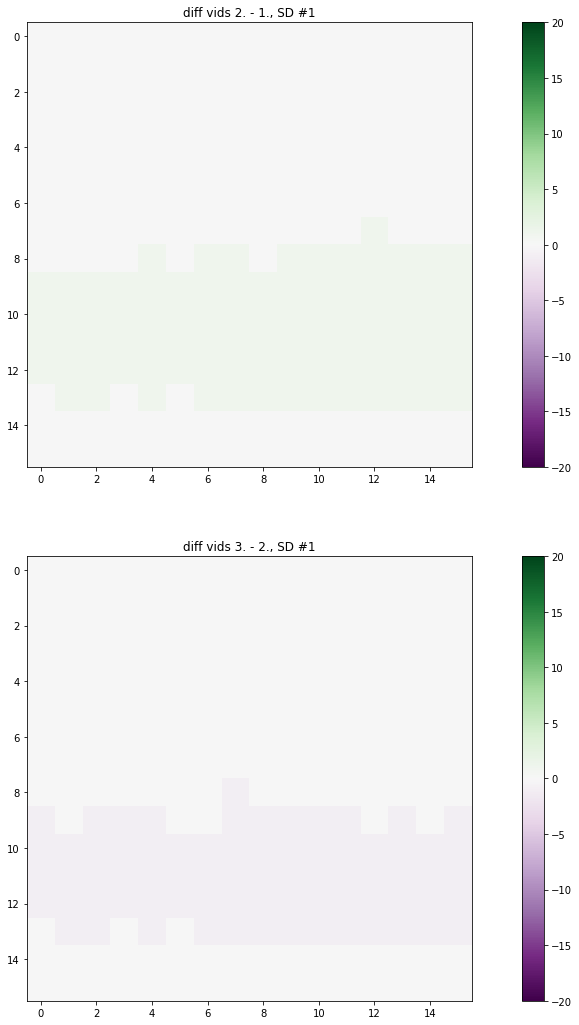

In [15]:
# TODO: set max and min values based on max and min differences encountered in data
VMIN = -20
VMAX = 20

if n_SD > 1:
    fig, axs = plt.subplots(nrows = n_vids - 1, ncols = n_SD, figsize = (18, 18))
    for i_vid in range(n_vids - 1):  # difference between videos was made -> number of differences = number of videos - 1
        for i_SD in range(n_SD):
            axs[i_vid][i_SD].set_title(f"diff vids {i_vid+2}. - {i_vid+1}., SD #{i_SD + 1}")
            pos = axs[i_vid][i_SD].imshow(onset_grids_diffs[i_vid][i_SD].transpose(), vmin=VMIN, vmax=VMAX, cmap="PRGn")
            fig.colorbar(pos, ax=axs[i_vid][i_SD])
    plt.show()
elif n_SD == 1:
    fig, axs = plt.subplots(nrows = n_vids - 1, ncols = n_SD, figsize = (18, 18))
    for i_vid in range(n_vids - 1):  # difference between videos was made -> number of differences = number of videos - 1
        axs[i_vid].set_title(f"diff vids {i_vid+2}. - {i_vid+1}., SD #1")
        pos = axs[i_vid].imshow(onset_grids_diffs[i_vid][0].transpose(), vmin=VMIN, vmax=VMAX, cmap="PRGn")
        fig.colorbar(pos, ax=axs[i_vid])
    plt.show()

In [ ]:
json_dicts

In [12]:
mouse_ID = "T329"

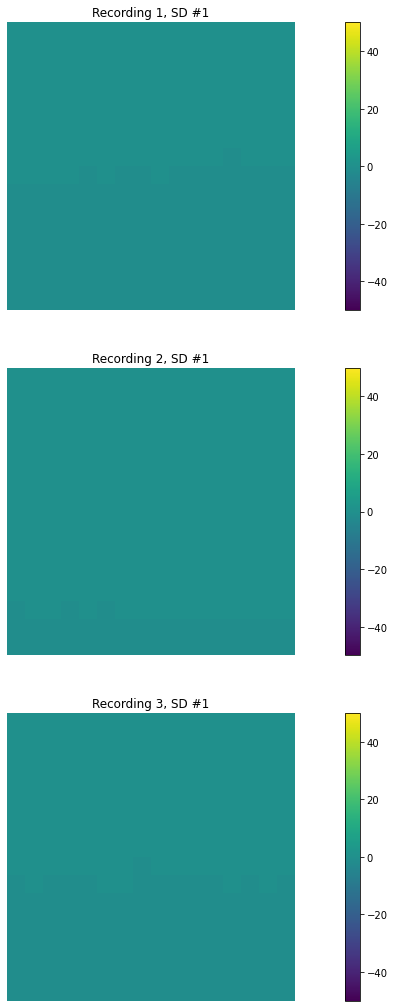

In [13]:
VMIN = -50
VMAX = 50


if n_SD > 1:
    fig, axs = plt.subplots(nrows = n_vids, ncols = n_SD, figsize = (18, 18) )
    plt.suptitle(f"{mouse_ID} Onset per recording (row) per SD (column)", fontsize=30)
    for i_vid in range(n_vids):
        for i_SD in range(n_SD):
            axs[i_vid][i_SD].set_title(f"Recording {i_vid+1}, SD #{i_SD + 1}")
            pos = axs[i_vid][i_SD].imshow(onset_grids_norm[i_vid][i_SD].transpose(), vmin=VMIN, vmax=VMAX)
            axs[i_vid][i_SD].axis('off')
            fig.colorbar(pos, ax=axs[i_vid][i_SD])

    #plt.show()

    now = datetime.now()
    fname = f"SDGrids_{now.year}-{now.month}-{now.day}_{now.hour}-{now.minute}-{now.second}"
    plt.savefig(f"D:\\PhD\\SDGrid\\{fname}.png", facecolor="white")
elif n_SD == 1:
    fig, axs = plt.subplots(nrows = n_vids, ncols = n_SD, figsize = (18, 18) )
    for i_vid in range(n_vids):
        axs[i_vid].set_title(f"Recording {i_vid+1}, SD #1")
        pos = axs[i_vid].imshow(onset_grids_norm[i_vid][0].transpose(), vmin=VMIN, vmax=VMAX)  # onset_grids_norm has shape [[vid1_SD1], [vid2_SD1] ...] if n_SD == 1
        axs[i_vid].axis('off')
        fig.colorbar(pos, ax=axs[i_vid])

else:
    print(f"Number of SD waves: {n_SD} invalid.")

In [ ]:
onset_grids_diff_to_first = [ [onset_grids_norm[i_vid][i_SD] - onset_grids_norm[0][i_SD] for i_SD in range(n_SD)] for i_vid in range(1, n_vids) ]

In [ ]:
VMIN = -45
VMAX = 45


fig, axs = plt.subplots(nrows = n_vids - 1, ncols = n_SD, figsize = (18, 18) )
for i_vid in range(n_vids - 1):  # difference between videos was made -> number of differences = number of videos - 1
    for i_SD in range(n_SD):
        axs[i_vid][i_SD].set_title(f"diff vids {i_vid+2}. - {i_vid+1}., SD #{i_SD + 1}")
        pos = axs[i_vid][i_SD].imshow(onset_grids_diff_to_first[i_vid][i_SD].transpose(), vmin=VMIN, vmax=VMAX, cmap="PRGn")
        fig.colorbar(pos, ax=axs[i_vid][i_SD])
plt.show()